In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

from sklearn.metrics import make_scorer
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

import joblib

In [2]:
def my_mean_euclidean_distance(y_true, y_pred):
    points = len(y_true)
    tot_sum = 0
    for i in range (points):
        tot_sum += LA.norm(y_true[i] - y_pred[i])
    
    return tot_sum / points

In [3]:
mean_euclidean_distance = make_scorer(my_mean_euclidean_distance, greater_is_better=False)

### Loading data

In [4]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'class1', 'class2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[7:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [5]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

In [6]:
x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

In [7]:
y1_mlcup_tr = y_mlcup_tr[:, 0]
y2_mlcup_tr = y_mlcup_tr[:, 1]

## KRR (first target)

### rbf kernel

In [9]:
alpha_range = np.logspace(-9, 0, 30, base = 2)
gamma_range = np.logspace(-9, 3, 10, base = 2)

param_grid = dict(
    alpha = alpha_range,
    gamma = gamma_range
)

kr = GridSearchCV(
    KernelRidge(kernel="rbf"),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

kr.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (kr.best_params_, kr.best_score_)
)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.054 total time=   0.0s
[CV 2/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 1/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 2/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.048 total time=   0.0s
[CV 3/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.051 total time=   0.0s
[CV 4/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.049 total time=   0.0s
[CV 1/4] END alpha=0.001953125, gamma=0.012401570718501554;, score=-0.048 total time=   0.0s
[CV 2/4] END alpha=0.001953125, gamma=0.012401570718501554;, score=-0.045 total time=   0.0s
[CV 3/4] END alpha=0.001953125, gamma=

[CV 3/4] END alpha=0.003003144596210125, gamma=0.012401570718501554;, score=-0.048 total time=   0.0s
[CV 4/4] END alpha=0.003003144596210125, gamma=0.012401570718501554;, score=-0.047 total time=   0.0s
[CV 1/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.045 total time=   0.0s
[CV 2/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.041 total time=   0.0s
[CV 2/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.040 total time=   0.0s
[CV 3/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.042 total time=   0.0s
[CV 4/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.041 total time=   0.0s
[CV 1/4] END alpha=0.003003144596210

[CV 2/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.040 total time=   0.0s
[CV 3/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.043 total time=   0.0s
[CV 4/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.042 total time=   0.0s
[CV 1/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.038 total time=   0.0s
[CV 2/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.036 total time=   0.0s
[CV 3/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=0.004617665262461984, gamma=0.5;, score=-0.035 total time=   0.0s
[CV 2/4] END alpha=0.004617665262461984, gamma=0.5;, score=-0.034 total time=   0.0s
[CV 3/4] END alpha=0.004617665262461984, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 4/4] END alpha=0.00461766526246198

[CV 4/4] END alpha=0.007100168437795797, gamma=0.19842513149602486;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.035 total time=   0.0s
[CV 2/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.034 total time=   0.0s
[CV 3/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 4/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.034 total time=   0.0s
[CV 1/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.035 total time=   0.0s
[CV 2/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.034 total time=   0.0s
[CV 3/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.037 total time=   0.0s
[CV 4/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.035 total time=   0.0s
[CV 1/4] END alpha=0.007100168437795797, gamma=3.174802103936398;, score=-0.039 total time=   0.0s
[CV 2/4] END alpha=0.007100168437795797, gamma=3.174802103936398

[CV 3/4] END alpha=0.01091729022778783, gamma=1.259921049894872;, score=-0.037 total time=   0.0s
[CV 4/4] END alpha=0.01091729022778783, gamma=1.259921049894872;, score=-0.034 total time=   0.0s
[CV 1/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.038 total time=   0.0s
[CV 2/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.037 total time=   0.0s
[CV 3/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.048 total time=   0.0s
[CV 2/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.049 total time=   0.0s
[CV 3/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.049 total time=   0.0s
[CV 4/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.047 total time=   0.0s
[CV 1/4] END alpha=0.013537484050129538, gamma=0.001953125;, score=-0.056 to

[CV 2/4] END alpha=0.016786534990253375, gamma=8.0;, score=-0.046 total time=   0.0s
[CV 3/4] END alpha=0.016786534990253375, gamma=8.0;, score=-0.048 total time=   0.0s
[CV 4/4] END alpha=0.016786534990253375, gamma=8.0;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.056 total time=   0.0s
[CV 2/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, s

[CV 2/4] END alpha=0.03200592375778116, gamma=0.0049215666011518475;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.03200592375778116, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.03200592375778116, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 1/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.054 total time=   0.0s
[CV 2/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.050 total time=   0.0s
[CV 3/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.052 total time=   0.0s
[CV 4/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.051 total time=   0.0s
[CV 1/4] END alpha=0.03200592375778116, gamma=0.03125;, score=-0.050 total time=   0.0s
[CV 2/4] END alpha=0.03200592375778116, gamma=0.03125;, score=-0.046 total time=   0.0s
[CV 3/4] END alpha=0.03200592375778116, gamma=0.03125;, score=-0.049 total time=   0.0s
[CV 4/4] END alpha=0.03200

[CV 3/4] END alpha=0.04921262949370557, gamma=0.03125;, score=-0.050 total time=   0.0s
[CV 4/4] END alpha=0.04921262949370557, gamma=0.03125;, score=-0.048 total time=   0.0s
[CV 1/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.046 total time=   0.0s
[CV 2/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.04921262949370557, gamma=0.19842513149602486;, score=-0.041 total time=   0.0s
[CV 2/4] END alpha=0.04921262949370557, gamma=0.19842513149602486;, score=-0.039 total time=   0.0s
[CV 3/4] END alpha=0.04921262949370557, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 4/4] END alpha=0.04921262949370557, gamma=0.19842513149602486;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.049

[CV 3/4] END alpha=0.0756698328726082, gamma=0.19842513149602486;, score=-0.043 total time=   0.0s
[CV 4/4] END alpha=0.0756698328726082, gamma=0.19842513149602486;, score=-0.041 total time=   0.0s
[CV 1/4] END alpha=0.0756698328726082, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 2/4] END alpha=0.0756698328726082, gamma=0.5;, score=-0.036 total time=   0.0s
[CV 3/4] END alpha=0.0756698328726082, gamma=0.5;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.0756698328726082, gamma=0.5;, score=-0.036 total time=   0.0s
[CV 1/4] END alpha=0.0756698328726082, gamma=1.259921049894872;, score=-0.035 total time=   0.0s
[CV 2/4] END alpha=0.0756698328726082, gamma=1.259921049894872;, score=-0.034 total time=   0.0s
[CV 3/4] END alpha=0.0756698328726082, gamma=1.259921049894872;, score=-0.037 total time=   0.0s
[CV 4/4] END alpha=0.0756698328726082, gamma=1.259921049894872;, score=-0.033 total time=   0.0s
[CV 1/4] END alpha=0.0756698328726082, gamma=3.174802103936398;, score=-0.036 tota

[CV 1/4] END alpha=0.11635069423999818, gamma=3.174802103936398;, score=-0.036 total time=   0.0s
[CV 2/4] END alpha=0.11635069423999818, gamma=3.174802103936398;, score=-0.034 total time=   0.0s
[CV 3/4] END alpha=0.11635069423999818, gamma=3.174802103936398;, score=-0.037 total time=   0.0s
[CV 4/4] END alpha=0.11635069423999818, gamma=3.174802103936398;, score=-0.033 total time=   0.0s
[CV 1/4] END alpha=0.11635069423999818, gamma=8.0;, score=-0.043 total time=   0.0s
[CV 2/4] END alpha=0.11635069423999818, gamma=8.0;, score=-0.041 total time=   0.0s
[CV 3/4] END alpha=0.11635069423999818, gamma=8.0;, score=-0.044 total time=   0.0s
[CV 4/4] END alpha=0.11635069423999818, gamma=8.0;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.14427533157324834, gamma=0.001953125;, score=-0.064 total time=   0.0s
[CV 2/4] END alpha=0.14427533157324834, gamma=0.001953125;, score=-0.055 total time=   0.0s
[CV 3/4] END alpha=0.14427533157324834, gamma=0.001953125;, score=-0.059 total time=   0

[CV 4/4] END alpha=0.17890199484013916, gamma=8.0;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.22183919737887975, gamma=0.001953125;, score=-0.069 total time=   0.0s
[CV 2/4] END alpha=0.22183919737887975, gamma=0.001953125;, score=-0.060 total time=   0.0s
[CV 3/4] END alpha=0.22183919737887975, gamma=0.001953125;, score=-0.064 total time=   0.0s
[CV 4/4] END alpha=0.22183919737887975, gamma=0.001953125;, score=-0.064 total time=   0.0s
[CV 1/4] END alpha=0.22183919737887975, gamma=0.0049215666011518475;, score=-0.061 total time=   0.0s
[CV 2/4] END alpha=0.22183919737887975, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 3/4] END alpha=0.22183919737887975, gamma=0.0049215666011518475;, score=-0.056 total time=   0.0s
[CV 4/4] END alpha=0.22183919737887975, gamma=0.0049215666011518475;, score=-0.056 total time=   0.0s
[CV 1/4] END alpha=0.22183919737887975, gamma=0.012401570718501554;, score=-0.057 total time=   0.0s
[CV 2/4] END alpha=0.22183919737887975,

[CV 4/4] END alpha=0.3411021756600187, gamma=0.0049215666011518475;, score=-0.058 total time=   0.0s
[CV 1/4] END alpha=0.3411021756600187, gamma=0.012401570718501554;, score=-0.058 total time=   0.0s
[CV 2/4] END alpha=0.3411021756600187, gamma=0.012401570718501554;, score=-0.052 total time=   0.0s
[CV 3/4] END alpha=0.3411021756600187, gamma=0.012401570718501554;, score=-0.054 total time=   0.0s
[CV 4/4] END alpha=0.3411021756600187, gamma=0.012401570718501554;, score=-0.054 total time=   0.0s
[CV 1/4] END alpha=0.3411021756600187, gamma=0.03125;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=0.3411021756600187, gamma=0.03125;, score=-0.050 total time=   0.0s
[CV 3/4] END alpha=0.3411021756600187, gamma=0.03125;, score=-0.052 total time=   0.0s
[CV 4/4] END alpha=0.3411021756600187, gamma=0.03125;, score=-0.052 total time=   0.0s
[CV 1/4] END alpha=0.3411021756600187, gamma=0.07874506561842956;, score=-0.051 total time=   0.0s
[CV 2/4] END alpha=0.3411021756600187, gamma=0.07874

[CV 1/4] END alpha=0.5244821276615171, gamma=0.07874506561842956;, score=-0.053 total time=   0.0s
[CV 2/4] END alpha=0.5244821276615171, gamma=0.07874506561842956;, score=-0.048 total time=   0.0s
[CV 3/4] END alpha=0.5244821276615171, gamma=0.07874506561842956;, score=-0.050 total time=   0.0s
[CV 4/4] END alpha=0.5244821276615171, gamma=0.07874506561842956;, score=-0.049 total time=   0.0s
[CV 1/4] END alpha=0.5244821276615171, gamma=0.19842513149602486;, score=-0.047 total time=   0.0s
[CV 2/4] END alpha=0.5244821276615171, gamma=0.19842513149602486;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.5244821276615171, gamma=0.19842513149602486;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.5244821276615171, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 1/4] END alpha=0.5244821276615171, gamma=0.5;, score=-0.040 total time=   0.0s
[CV 2/4] END alpha=0.5244821276615171, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 3/4] END alpha=0.5244821276615171, gam

[CV 3/4] END alpha=0.8064489817576826, gamma=0.5;, score=-0.042 total time=   0.0s
[CV 4/4] END alpha=0.8064489817576826, gamma=0.5;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.8064489817576826, gamma=1.259921049894872;, score=-0.037 total time=   0.0s
[CV 2/4] END alpha=0.8064489817576826, gamma=1.259921049894872;, score=-0.036 total time=   0.0s
[CV 3/4] END alpha=0.8064489817576826, gamma=1.259921049894872;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.8064489817576826, gamma=1.259921049894872;, score=-0.035 total time=   0.0s
[CV 1/4] END alpha=0.8064489817576826, gamma=3.174802103936398;, score=-0.040 total time=   0.0s
[CV 2/4] END alpha=0.8064489817576826, gamma=3.174802103936398;, score=-0.037 total time=   0.0s
[CV 3/4] END alpha=0.8064489817576826, gamma=3.174802103936398;, score=-0.041 total time=   0.0s
[CV 4/4] END alpha=0.8064489817576826, gamma=3.174802103936398;, score=-0.036 total time=   0.0s
[CV 1/4] END alpha=0.8064489817576826, gamma=8.0;, score=-

In [11]:
rbf_krr_1 = KernelRidge(
    alpha = kr.best_params_['alpha'],
    gamma = kr.best_params_['gamma'],
    kernel = 'rbf'
)
rbf_results_1 = rbf_krr_1.fit(x_mlcup_tr, y1_mlcup_tr)

### linear kernel

In [12]:
alpha_range = np.logspace(-9, 0, 30, base = 2)

param_grid = dict(
    alpha = alpha_range
)

kr = GridSearchCV(
    KernelRidge(kernel="linear"),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

kr.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (kr.best_params_, kr.best_score_)
)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV 1/4] END ................alpha=0.001953125;, score=-0.067 total time=   0.0s
[CV 2/4] END ................alpha=0.001953125;, score=-0.061 total time=   0.0s
[CV 3/4] END ................alpha=0.001953125;, score=-0.066 total time=   0.0s
[CV 4/4] END ................alpha=0.001953125;, score=-0.063 total time=   0.0s
[CV 1/4] END ......alpha=0.0024218829016847392;, score=-0.067 total time=   0.0s
[CV 2/4] END ......alpha=0.0024218829016847392;, score=-0.061 total time=   0.0s
[CV 3/4] END ......alpha=0.0024218829016847392;, score=-0.066 total time=   0.0s
[CV 4/4] END ......alpha=0.0024218829016847392;, score=-0.063 total time=   0.0s
[CV 1/4] END .......alpha=0.003003144596210125;, score=-0.067 total time=   0.0s
[CV 2/4] END .......alpha=0.003003144596210125;, score=-0.061 total time=   0.0s
[CV 3/4] END .......alpha=0.003003144596210125;, score=-0.066 total time=   0.0s
[CV 4/4] END .......alpha=0.003003144596210125;

[CV 3/4] END ........alpha=0.42296807780273343;, score=-0.066 total time=   0.0s
[CV 4/4] END ........alpha=0.42296807780273343;, score=-0.063 total time=   0.0s
[CV 1/4] END .........alpha=0.5244821276615171;, score=-0.067 total time=   0.0s
[CV 2/4] END .........alpha=0.5244821276615171;, score=-0.061 total time=   0.0s
[CV 3/4] END .........alpha=0.5244821276615171;, score=-0.066 total time=   0.0s
[CV 4/4] END .........alpha=0.5244821276615171;, score=-0.063 total time=   0.0s
[CV 1/4] END .........alpha=0.6503599601780032;, score=-0.067 total time=   0.0s
[CV 2/4] END .........alpha=0.6503599601780032;, score=-0.061 total time=   0.0s
[CV 3/4] END .........alpha=0.6503599601780032;, score=-0.066 total time=   0.0s
[CV 4/4] END .........alpha=0.6503599601780032;, score=-0.063 total time=   0.0s
[CV 1/4] END .........alpha=0.8064489817576826;, score=-0.067 total time=   0.0s
[CV 2/4] END .........alpha=0.8064489817576826;, score=-0.061 total time=   0.0s
[CV 3/4] END .........alpha=

In [14]:
linear_krr_1 = KernelRidge(
    alpha = kr.best_params_['alpha'],
    kernel = 'linear'
)
linear_results_1 = linear_krr_1.fit(x_mlcup_tr, y1_mlcup_tr)

### polynomial kernel

In [15]:
degree_range = np.arange(2, 8, 1)
alpha_range = np.logspace(-9, 0, 10, base = 2)
gamma_range = np.logspace(-9, 3, 10, base = 2)

param_grid = dict(
    degree = degree_range,
    alpha = alpha_range,
    gamma = gamma_range
)

kr = GridSearchCV(
    KernelRidge(kernel = 'poly'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

kr.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (kr.best_params_, kr.best_score_)
)

Fitting 4 folds for each of 600 candidates, totalling 2400 fits
[CV 1/4] END alpha=0.001953125, degree=2, gamma=0.001953125;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=2, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=2, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=2, gamma=0.001953125;, score=-0.052 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=2, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=2, gamma=0.0049215666011518475;, score=-0.050 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=2, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=2, gamma=0.0049215666011518475;, score=-0.050 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=2, gamma=0.012401570718501554;, score=-0.049 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=2,

[CV 2/4] END alpha=0.001953125, degree=4, gamma=0.0049215666011518475;, score=-0.046 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=4, gamma=0.0049215666011518475;, score=-0.049 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=4, gamma=0.0049215666011518475;, score=-0.047 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=4, gamma=0.012401570718501554;, score=-0.046 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=4, gamma=0.012401570718501554;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=4, gamma=0.012401570718501554;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=4, gamma=0.012401570718501554;, score=-0.046 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=4, gamma=0.03125;, score=-0.043 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=4, gamma=0.03125;, score=-0.042 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=4, gamma=0.03125;, score=-0.044 total time=   0.0s
[CV 4/

[CV 4/4] END alpha=0.001953125, degree=6, gamma=0.012401570718501554;, score=-0.045 total time=   0.1s
[CV 1/4] END alpha=0.001953125, degree=6, gamma=0.03125;, score=-0.040 total time=   0.1s
[CV 2/4] END alpha=0.001953125, degree=6, gamma=0.03125;, score=-0.039 total time=   0.1s
[CV 3/4] END alpha=0.001953125, degree=6, gamma=0.03125;, score=-0.042 total time=   0.1s
[CV 4/4] END alpha=0.001953125, degree=6, gamma=0.03125;, score=-0.040 total time=   0.1s
[CV 1/4] END alpha=0.001953125, degree=6, gamma=0.07874506561842956;, score=-0.037 total time=   0.1s
[CV 2/4] END alpha=0.001953125, degree=6, gamma=0.07874506561842956;, score=-0.036 total time=   0.1s
[CV 3/4] END alpha=0.001953125, degree=6, gamma=0.07874506561842956;, score=-0.039 total time=   0.1s
[CV 4/4] END alpha=0.001953125, degree=6, gamma=0.07874506561842956;, score=-0.036 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=6, gamma=0.19842513149602486;, score=-0.036 total time=   0.0s
[CV 2/4] END alpha=0.001953

[CV 2/4] END alpha=0.00390625, degree=2, gamma=0.07874506561842956;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=2, gamma=0.07874506561842956;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=2, gamma=0.07874506561842956;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=2, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=2, gamma=0.19842513149602486;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=2, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=2, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=2, gamma=0.5;, score=-0.046 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=2, gamma=0.5;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=2, gamma=0.5;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=

[CV 1/4] END alpha=0.00390625, degree=4, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=4, gamma=0.5;, score=-0.036 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=4, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=4, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=4, gamma=1.259921049894872;, score=-0.041 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=4, gamma=1.259921049894872;, score=-0.040 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=4, gamma=1.259921049894872;, score=-0.042 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=4, gamma=1.259921049894872;, score=-0.042 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=4, gamma=3.174802103936398;, score=-0.052 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=4, gamma=3.174802103936398;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=4, gamma=3.174802103936398;,

[CV 3/4] END alpha=0.00390625, degree=6, gamma=1.259921049894872;, score=-0.068 total time=   0.1s
[CV 4/4] END alpha=0.00390625, degree=6, gamma=1.259921049894872;, score=-0.065 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=6, gamma=3.174802103936398;, score=-0.178 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=6, gamma=3.174802103936398;, score=-0.182 total time=   0.1s
[CV 3/4] END alpha=0.00390625, degree=6, gamma=3.174802103936398;, score=-0.185 total time=   0.1s
[CV 4/4] END alpha=0.00390625, degree=6, gamma=3.174802103936398;, score=-0.177 total time=   0.1s
[CV 1/4] END alpha=0.00390625, degree=6, gamma=8.0;, score=-0.240 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=6, gamma=8.0;, score=-0.235 total time=   0.1s
[CV 3/4] END alpha=0.00390625, degree=6, gamma=8.0;, score=-0.264 total time=   0.1s
[CV 4/4] END alpha=0.00390625, degree=6, gamma=8.0;, score=-0.251 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=7, gamma=0.001953125;, score

[CV 2/4] END alpha=0.0078125, degree=2, gamma=8.0;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=2, gamma=8.0;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=2, gamma=8.0;, score=-0.044 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=3, gamma=0.001953125;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=3, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=3, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=3, gamma=0.001953125;, score=-0.052 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=3, gamma=0.0049215666011518475;, score=-0.054 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=3, gamma=0.0049215666011518475;, score=-0.050 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=3, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=3, gamma=0.0049215666011518475;, scor

[CV 2/4] END alpha=0.0078125, degree=5, gamma=0.0049215666011518475;, score=-0.048 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=5, gamma=0.0049215666011518475;, score=-0.050 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=5, gamma=0.0049215666011518475;, score=-0.049 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=5, gamma=0.012401570718501554;, score=-0.047 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=5, gamma=0.012401570718501554;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=5, gamma=0.012401570718501554;, score=-0.047 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=5, gamma=0.012401570718501554;, score=-0.046 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=5, gamma=0.03125;, score=-0.044 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=5, gamma=0.03125;, score=-0.042 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=5, gamma=0.03125;, score=-0.045 total time=   0.0s
[CV 4/4] END alpha=0.00781

[CV 2/4] END alpha=0.0078125, degree=7, gamma=0.03125;, score=-0.040 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=7, gamma=0.03125;, score=-0.043 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=7, gamma=0.03125;, score=-0.042 total time=   0.1s
[CV 1/4] END alpha=0.0078125, degree=7, gamma=0.07874506561842956;, score=-0.038 total time=   0.1s
[CV 2/4] END alpha=0.0078125, degree=7, gamma=0.07874506561842956;, score=-0.037 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=7, gamma=0.07874506561842956;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=7, gamma=0.07874506561842956;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=7, gamma=0.19842513149602486;, score=-0.036 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=7, gamma=0.19842513149602486;, score=-0.036 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=7, gamma=0.19842513149602486;, score=-0.038 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree

[CV 2/4] END alpha=0.015625, degree=3, gamma=0.19842513149602486;, score=-0.039 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=3, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=3, gamma=0.19842513149602486;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.015625, degree=3, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 2/4] END alpha=0.015625, degree=3, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=3, gamma=0.5;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=3, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=0.015625, degree=3, gamma=1.259921049894872;, score=-0.038 total time=   0.0s
[CV 2/4] END alpha=0.015625, degree=3, gamma=1.259921049894872;, score=-0.037 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=3, gamma=1.259921049894872;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=3, gamma=1.259921049894872;, score=-0.037 to

[CV 3/4] END alpha=0.015625, degree=5, gamma=1.259921049894872;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=5, gamma=1.259921049894872;, score=-0.042 total time=   0.0s
[CV 1/4] END alpha=0.015625, degree=5, gamma=3.174802103936398;, score=-0.066 total time=   0.0s
[CV 2/4] END alpha=0.015625, degree=5, gamma=3.174802103936398;, score=-0.074 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=5, gamma=3.174802103936398;, score=-0.072 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=5, gamma=3.174802103936398;, score=-0.066 total time=   0.0s
[CV 1/4] END alpha=0.015625, degree=5, gamma=8.0;, score=-0.166 total time=   0.0s
[CV 2/4] END alpha=0.015625, degree=5, gamma=8.0;, score=-0.173 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=5, gamma=8.0;, score=-0.165 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=5, gamma=8.0;, score=-0.164 total time=   0.0s
[CV 1/4] END alpha=0.015625, degree=6, gamma=0.001953125;, score=-0.055 total time=   

[CV 4/4] END alpha=0.015625, degree=7, gamma=8.0;, score=-0.234 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=2, gamma=0.001953125;, score=-0.057 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=2, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=2, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.03125, degree=2, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=2, gamma=0.0049215666011518475;, score=-0.056 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=2, gamma=0.0049215666011518475;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=2, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.03125, degree=2, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=2, gamma=0.012401570718501554;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=2, gamma=0.012401570718

[CV 2/4] END alpha=0.03125, degree=4, gamma=0.012401570718501554;, score=-0.048 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=4, gamma=0.012401570718501554;, score=-0.051 total time=   0.0s
[CV 4/4] END alpha=0.03125, degree=4, gamma=0.012401570718501554;, score=-0.049 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=4, gamma=0.03125;, score=-0.047 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=4, gamma=0.03125;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=4, gamma=0.03125;, score=-0.047 total time=   0.0s
[CV 4/4] END alpha=0.03125, degree=4, gamma=0.03125;, score=-0.046 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=4, gamma=0.07874506561842956;, score=-0.044 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=4, gamma=0.07874506561842956;, score=-0.041 total time=   0.1s
[CV 3/4] END alpha=0.03125, degree=4, gamma=0.07874506561842956;, score=-0.044 total time=   0.1s
[CV 4/4] END alpha=0.03125, degree=4, gamma=0.07874506561842956;,

[CV 4/4] END alpha=0.03125, degree=6, gamma=0.07874506561842956;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=6, gamma=0.19842513149602486;, score=-0.037 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=6, gamma=0.19842513149602486;, score=-0.036 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=6, gamma=0.19842513149602486;, score=-0.038 total time=   0.0s
[CV 4/4] END alpha=0.03125, degree=6, gamma=0.19842513149602486;, score=-0.036 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=6, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=6, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=6, gamma=0.5;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.03125, degree=6, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=6, gamma=1.259921049894872;, score=-0.050 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=6, gamma=1.259921049894872;, score=-0.051 total tim

[CV 2/4] END alpha=0.0625, degree=2, gamma=1.259921049894872;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=2, gamma=1.259921049894872;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=2, gamma=1.259921049894872;, score=-0.044 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=2, gamma=3.174802103936398;, score=-0.046 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=2, gamma=3.174802103936398;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=2, gamma=3.174802103936398;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=2, gamma=3.174802103936398;, score=-0.044 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=2, gamma=8.0;, score=-0.046 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=2, gamma=8.0;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=2, gamma=8.0;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=2, gamma=8.0;, score=-0.044 total time=   0.0s
[CV 1/4] EN

[CV 1/4] END alpha=0.0625, degree=5, gamma=0.001953125;, score=-0.057 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=5, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=5, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=5, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=5, gamma=0.0049215666011518475;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=5, gamma=0.0049215666011518475;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=5, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=5, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=5, gamma=0.012401570718501554;, score=-0.052 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=5, gamma=0.012401570718501554;, score=-0.048 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=5, gamma=0.0124015

[CV 3/4] END alpha=0.0625, degree=7, gamma=0.012401570718501554;, score=-0.049 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=7, gamma=0.012401570718501554;, score=-0.048 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=7, gamma=0.03125;, score=-0.046 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=7, gamma=0.03125;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=7, gamma=0.03125;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=7, gamma=0.03125;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=7, gamma=0.07874506561842956;, score=-0.040 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=7, gamma=0.07874506561842956;, score=-0.039 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=7, gamma=0.07874506561842956;, score=-0.041 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=7, gamma=0.07874506561842956;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=7, gamma=0.19842513149602486;, score=-0.03

[CV 1/4] END alpha=0.125, degree=3, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 2/4] END alpha=0.125, degree=3, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 3/4] END alpha=0.125, degree=3, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 4/4] END alpha=0.125, degree=3, gamma=0.19842513149602486;, score=-0.044 total time=   0.1s
[CV 1/4] END .alpha=0.125, degree=3, gamma=0.5;, score=-0.039 total time=   0.0s
[CV 2/4] END .alpha=0.125, degree=3, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 3/4] END .alpha=0.125, degree=3, gamma=0.5;, score=-0.041 total time=   0.1s
[CV 4/4] END .alpha=0.125, degree=3, gamma=0.5;, score=-0.039 total time=   0.0s
[CV 1/4] END alpha=0.125, degree=3, gamma=1.259921049894872;, score=-0.038 total time=   0.0s
[CV 2/4] END alpha=0.125, degree=3, gamma=1.259921049894872;, score=-0.037 total time=   0.0s
[CV 3/4] END alpha=0.125, degree=3, gamma=1.259921049894872;, score=-0.039 total time=   0.0s
[CV 4/4] E

[CV 1/4] END alpha=0.125, degree=5, gamma=3.174802103936398;, score=-0.053 total time=   0.0s
[CV 2/4] END alpha=0.125, degree=5, gamma=3.174802103936398;, score=-0.054 total time=   0.0s
[CV 3/4] END alpha=0.125, degree=5, gamma=3.174802103936398;, score=-0.055 total time=   0.0s
[CV 4/4] END alpha=0.125, degree=5, gamma=3.174802103936398;, score=-0.048 total time=   0.0s
[CV 1/4] END .alpha=0.125, degree=5, gamma=8.0;, score=-0.104 total time=   0.0s
[CV 2/4] END .alpha=0.125, degree=5, gamma=8.0;, score=-0.114 total time=   0.0s
[CV 3/4] END .alpha=0.125, degree=5, gamma=8.0;, score=-0.105 total time=   0.0s
[CV 4/4] END .alpha=0.125, degree=5, gamma=8.0;, score=-0.103 total time=   0.0s
[CV 1/4] END alpha=0.125, degree=6, gamma=0.001953125;, score=-0.058 total time=   0.0s
[CV 2/4] END alpha=0.125, degree=6, gamma=0.001953125;, score=-0.052 total time=   0.0s
[CV 3/4] END alpha=0.125, degree=6, gamma=0.001953125;, score=-0.054 total time=   0.0s
[CV 4/4] END alpha=0.125, degree=6, 

[CV 2/4] END alpha=0.25, degree=2, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=2, gamma=0.0049215666011518475;, score=-0.056 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=2, gamma=0.0049215666011518475;, score=-0.056 total time=   0.0s
[CV 1/4] END alpha=0.25, degree=2, gamma=0.012401570718501554;, score=-0.058 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=2, gamma=0.012401570718501554;, score=-0.052 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=2, gamma=0.012401570718501554;, score=-0.054 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=2, gamma=0.012401570718501554;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.25, degree=2, gamma=0.03125;, score=-0.056 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=2, gamma=0.03125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=2, gamma=0.03125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=2, gamma=0.03125;, score=-0.052 total time= 

[CV 1/4] END alpha=0.25, degree=4, gamma=0.07874506561842956;, score=-0.048 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=4, gamma=0.07874506561842956;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=4, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=4, gamma=0.07874506561842956;, score=-0.046 total time=   0.1s
[CV 1/4] END alpha=0.25, degree=4, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=4, gamma=0.19842513149602486;, score=-0.040 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=4, gamma=0.19842513149602486;, score=-0.043 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=4, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 1/4] END ..alpha=0.25, degree=4, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 2/4] END ..alpha=0.25, degree=4, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 3/4] END ..alpha=0.25, degree=4, gamma=0.5;, score=-0.039 total time=   0.

[CV 1/4] END alpha=0.25, degree=6, gamma=1.259921049894872;, score=-0.043 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=6, gamma=1.259921049894872;, score=-0.042 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=6, gamma=1.259921049894872;, score=-0.044 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=6, gamma=1.259921049894872;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.25, degree=6, gamma=3.174802103936398;, score=-0.076 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=6, gamma=3.174802103936398;, score=-0.084 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=6, gamma=3.174802103936398;, score=-0.081 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=6, gamma=3.174802103936398;, score=-0.076 total time=   0.0s
[CV 1/4] END ..alpha=0.25, degree=6, gamma=8.0;, score=-0.205 total time=   0.0s
[CV 2/4] END ..alpha=0.25, degree=6, gamma=8.0;, score=-0.206 total time=   0.0s
[CV 3/4] END ..alpha=0.25, degree=6, gamma=8.0;, score=-0.228 total time=   0.0s
[CV 4/4] END 

[CV 2/4] END alpha=0.5, degree=3, gamma=0.001953125;, score=-0.068 total time=   0.0s
[CV 3/4] END alpha=0.5, degree=3, gamma=0.001953125;, score=-0.071 total time=   0.1s
[CV 4/4] END alpha=0.5, degree=3, gamma=0.001953125;, score=-0.072 total time=   0.1s
[CV 1/4] END alpha=0.5, degree=3, gamma=0.0049215666011518475;, score=-0.063 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=3, gamma=0.0049215666011518475;, score=-0.054 total time=   0.0s
[CV 3/4] END alpha=0.5, degree=3, gamma=0.0049215666011518475;, score=-0.058 total time=   0.0s
[CV 4/4] END alpha=0.5, degree=3, gamma=0.0049215666011518475;, score=-0.058 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=3, gamma=0.012401570718501554;, score=-0.058 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=3, gamma=0.012401570718501554;, score=-0.052 total time=   0.0s
[CV 3/4] END alpha=0.5, degree=3, gamma=0.012401570718501554;, score=-0.054 total time=   0.0s
[CV 4/4] END alpha=0.5, degree=3, gamma=0.012401570718501554;, score=-0.0

[CV 2/4] END alpha=0.5, degree=5, gamma=0.03125;, score=-0.049 total time=   0.0s
[CV 3/4] END alpha=0.5, degree=5, gamma=0.03125;, score=-0.051 total time=   0.0s
[CV 4/4] END alpha=0.5, degree=5, gamma=0.03125;, score=-0.050 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=5, gamma=0.07874506561842956;, score=-0.048 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=5, gamma=0.07874506561842956;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.5, degree=5, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 4/4] END alpha=0.5, degree=5, gamma=0.07874506561842956;, score=-0.046 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=5, gamma=0.19842513149602486;, score=-0.041 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=5, gamma=0.19842513149602486;, score=-0.039 total time=   0.1s
[CV 3/4] END alpha=0.5, degree=5, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 4/4] END alpha=0.5, degree=5, gamma=0.19842513149602486;, score=-0.041 total time=   0.0s
[C

[CV 2/4] END ...alpha=0.5, degree=7, gamma=0.5;, score=-0.036 total time=   0.0s
[CV 3/4] END ...alpha=0.5, degree=7, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 4/4] END ...alpha=0.5, degree=7, gamma=0.5;, score=-0.036 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=7, gamma=1.259921049894872;, score=-0.048 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=7, gamma=1.259921049894872;, score=-0.048 total time=   0.0s
[CV 3/4] END alpha=0.5, degree=7, gamma=1.259921049894872;, score=-0.050 total time=   0.0s
[CV 4/4] END alpha=0.5, degree=7, gamma=1.259921049894872;, score=-0.044 total time=   0.1s
[CV 1/4] END alpha=0.5, degree=7, gamma=3.174802103936398;, score=-0.132 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=7, gamma=3.174802103936398;, score=-0.140 total time=   0.0s
[CV 3/4] END alpha=0.5, degree=7, gamma=3.174802103936398;, score=-0.134 total time=   0.0s
[CV 4/4] END alpha=0.5, degree=7, gamma=3.174802103936398;, score=-0.130 total time=   0.0s
[CV 1/4] END ...alpha

[CV 3/4] END ...alpha=1.0, degree=3, gamma=8.0;, score=-0.039 total time=   0.0s
[CV 4/4] END ...alpha=1.0, degree=3, gamma=8.0;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=1.0, degree=4, gamma=0.001953125;, score=-0.092 total time=   0.0s
[CV 2/4] END alpha=1.0, degree=4, gamma=0.001953125;, score=-0.081 total time=   0.0s
[CV 3/4] END alpha=1.0, degree=4, gamma=0.001953125;, score=-0.083 total time=   0.0s
[CV 4/4] END alpha=1.0, degree=4, gamma=0.001953125;, score=-0.086 total time=   0.0s
[CV 1/4] END alpha=1.0, degree=4, gamma=0.0049215666011518475;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=1.0, degree=4, gamma=0.0049215666011518475;, score=-0.058 total time=   0.0s
[CV 3/4] END alpha=1.0, degree=4, gamma=0.0049215666011518475;, score=-0.062 total time=   0.0s
[CV 4/4] END alpha=1.0, degree=4, gamma=0.0049215666011518475;, score=-0.062 total time=   0.0s
[CV 1/4] END alpha=1.0, degree=4, gamma=0.012401570718501554;, score=-0.060 total time=   0.0s
[CV 2/4] END al

[CV 3/4] END alpha=1.0, degree=6, gamma=0.012401570718501554;, score=-0.054 total time=   0.0s
[CV 4/4] END alpha=1.0, degree=6, gamma=0.012401570718501554;, score=-0.054 total time=   0.1s
[CV 1/4] END alpha=1.0, degree=6, gamma=0.03125;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=1.0, degree=6, gamma=0.03125;, score=-0.050 total time=   0.0s
[CV 3/4] END alpha=1.0, degree=6, gamma=0.03125;, score=-0.052 total time=   0.0s
[CV 4/4] END alpha=1.0, degree=6, gamma=0.03125;, score=-0.051 total time=   0.0s
[CV 1/4] END alpha=1.0, degree=6, gamma=0.07874506561842956;, score=-0.048 total time=   0.0s
[CV 2/4] END alpha=1.0, degree=6, gamma=0.07874506561842956;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=1.0, degree=6, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 4/4] END alpha=1.0, degree=6, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 1/4] END alpha=1.0, degree=6, gamma=0.19842513149602486;, score=-0.041 total time=   0.0s
[CV 2/4] END

In [16]:
poly_krr_1 = KernelRidge(
    alpha = kr.best_params_['alpha'],
    gamma = kr.best_params_['gamma'],
    degree = kr.best_params_['degree'],
    kernel = 'poly'
)
poly_results_1 = poly_krr_1.fit(x_mlcup_tr, y1_mlcup_tr)

## KRR (second target)

### rbf kernel

In [17]:
alpha_range = np.logspace(-9, 0, 30, base = 2)
gamma_range = np.logspace(-9, 3, 10, base = 2)

param_grid = dict(
    alpha = alpha_range,
    gamma = gamma_range
)

kr = GridSearchCV(
    KernelRidge(kernel="rbf"),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

kr.fit(x_mlcup_tr, y2_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (kr.best_params_, kr.best_score_)
)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.082 total time=   0.0s
[CV 2/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.079 total time=   0.0s
[CV 3/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.082 total time=   0.0s
[CV 4/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.078 total time=   0.0s
[CV 1/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.077 total time=   0.0s
[CV 2/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.075 total time=   0.0s
[CV 3/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.077 total time=   0.0s
[CV 4/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.074 total time=   0.0s
[CV 1/4] END alpha=0.001953125, gamma=0.012401570718501554;, score=-0.069 total time=   0.0s
[CV 2/4] END alpha=0.001953125, gamma=0.012401570718501554;, score=-0.067 total time=   0.0s
[CV 3/4] END alpha=0.001953125, gamma=

[CV 3/4] END alpha=0.003003144596210125, gamma=0.012401570718501554;, score=-0.071 total time=   0.0s
[CV 4/4] END alpha=0.003003144596210125, gamma=0.012401570718501554;, score=-0.068 total time=   0.0s
[CV 1/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.066 total time=   0.0s
[CV 2/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.064 total time=   0.0s
[CV 3/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.063 total time=   0.0s
[CV 4/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.062 total time=   0.0s
[CV 1/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.064 total time=   0.0s
[CV 2/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.062 total time=   0.0s
[CV 3/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.060 total time=   0.0s
[CV 4/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.060 total time=   0.0s
[CV 1/4] END alpha=0.003003144596210

[CV 1/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.064 total time=   0.0s
[CV 2/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.062 total time=   0.0s
[CV 3/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.061 total time=   0.0s
[CV 4/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.060 total time=   0.0s
[CV 1/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.063 total time=   0.0s
[CV 2/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.060 total time=   0.0s
[CV 3/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.058 total time=   0.0s
[CV 4/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.058 total time=   0.0s
[CV 1/4] END alpha=0.004617665262461984, gamma=0.5;, score=-0.061 total time=   0.0s
[CV 2/4] END alpha=0.004617665262461984, gamma=0.5;, score=-0.059 total time=   0.0s
[CV 3/4] END alpha=0.0

[CV 3/4] END alpha=0.007100168437795797, gamma=0.19842513149602486;, score=-0.059 total time=   0.0s
[CV 4/4] END alpha=0.007100168437795797, gamma=0.19842513149602486;, score=-0.058 total time=   0.0s
[CV 1/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.060 total time=   0.0s
[CV 2/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.059 total time=   0.0s
[CV 3/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.057 total time=   0.0s
[CV 4/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.054 total time=   0.0s
[CV 1/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.060 total time=   0.0s
[CV 2/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.060 total time=   0.0s
[CV 3/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.058 total time=   0.0s
[CV 4/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.055 total time=   0.0s
[CV 1/4] END alpha=0.007100168437795797, gamma=3.1748021039363

[CV 3/4] END alpha=0.01091729022778783, gamma=1.259921049894872;, score=-0.057 total time=   0.0s
[CV 4/4] END alpha=0.01091729022778783, gamma=1.259921049894872;, score=-0.054 total time=   0.0s
[CV 1/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.064 total time=   0.0s
[CV 2/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.065 total time=   0.0s
[CV 3/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.061 total time=   0.0s
[CV 4/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.060 total time=   0.0s
[CV 1/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.076 total time=   0.0s
[CV 2/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.085 total time=   0.0s
[CV 3/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.075 total time=   0.0s
[CV 4/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.074 total time=   0.0s
[CV 1/4] END alpha=0.013537484050129538, gamma=0.001953125;, score=-0.083 to

[CV 1/4] END alpha=0.016786534990253375, gamma=8.0;, score=-0.073 total time=   0.0s
[CV 2/4] END alpha=0.016786534990253375, gamma=8.0;, score=-0.079 total time=   0.0s
[CV 3/4] END alpha=0.016786534990253375, gamma=8.0;, score=-0.071 total time=   0.0s
[CV 4/4] END alpha=0.016786534990253375, gamma=8.0;, score=-0.070 total time=   0.0s
[CV 1/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.083 total time=   0.0s
[CV 2/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.079 total time=   0.0s
[CV 3/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.082 total time=   0.0s
[CV 4/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.079 total time=   0.0s
[CV 1/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, score=-0.082 total time=   0.0s
[CV 2/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, score=-0.079 total time=   0.0s
[CV 3/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, score=-0.082 total

[CV 4/4] END alpha=0.03200592375778116, gamma=0.001953125;, score=-0.081 total time=   0.0s
[CV 1/4] END alpha=0.03200592375778116, gamma=0.0049215666011518475;, score=-0.083 total time=   0.0s
[CV 2/4] END alpha=0.03200592375778116, gamma=0.0049215666011518475;, score=-0.079 total time=   0.0s
[CV 3/4] END alpha=0.03200592375778116, gamma=0.0049215666011518475;, score=-0.082 total time=   0.0s
[CV 4/4] END alpha=0.03200592375778116, gamma=0.0049215666011518475;, score=-0.079 total time=   0.0s
[CV 1/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.080 total time=   0.0s
[CV 2/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.077 total time=   0.0s
[CV 3/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.080 total time=   0.0s
[CV 4/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.076 total time=   0.0s
[CV 1/4] END alpha=0.03200592375778116, gamma=0.03125;, score=-0.073 total time=   0.0s
[CV 2/4]

[CV 3/4] END alpha=0.04921262949370557, gamma=0.012401570718501554;, score=-0.081 total time=   0.0s
[CV 4/4] END alpha=0.04921262949370557, gamma=0.012401570718501554;, score=-0.077 total time=   0.0s
[CV 1/4] END alpha=0.04921262949370557, gamma=0.03125;, score=-0.075 total time=   0.0s
[CV 2/4] END alpha=0.04921262949370557, gamma=0.03125;, score=-0.073 total time=   0.0s
[CV 3/4] END alpha=0.04921262949370557, gamma=0.03125;, score=-0.075 total time=   0.0s
[CV 4/4] END alpha=0.04921262949370557, gamma=0.03125;, score=-0.072 total time=   0.0s
[CV 1/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.066 total time=   0.0s
[CV 3/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.064 total time=   0.0s
[CV 1/4] END alpha=0.04921262949370557, gamma=

[CV 2/4] END alpha=0.0756698328726082, gamma=0.07874506561842956;, score=-0.067 total time=   0.0s
[CV 3/4] END alpha=0.0756698328726082, gamma=0.07874506561842956;, score=-0.068 total time=   0.0s
[CV 4/4] END alpha=0.0756698328726082, gamma=0.07874506561842956;, score=-0.066 total time=   0.0s
[CV 1/4] END alpha=0.0756698328726082, gamma=0.19842513149602486;, score=-0.064 total time=   0.0s
[CV 2/4] END alpha=0.0756698328726082, gamma=0.19842513149602486;, score=-0.062 total time=   0.0s
[CV 3/4] END alpha=0.0756698328726082, gamma=0.19842513149602486;, score=-0.061 total time=   0.0s
[CV 4/4] END alpha=0.0756698328726082, gamma=0.19842513149602486;, score=-0.060 total time=   0.0s
[CV 1/4] END alpha=0.0756698328726082, gamma=0.5;, score=-0.062 total time=   0.0s
[CV 2/4] END alpha=0.0756698328726082, gamma=0.5;, score=-0.059 total time=   0.0s
[CV 3/4] END alpha=0.0756698328726082, gamma=0.5;, score=-0.057 total time=   0.0s
[CV 4/4] END alpha=0.0756698328726082, gamma=0.5;, score=-

[CV 3/4] END alpha=0.11635069423999818, gamma=0.5;, score=-0.057 total time=   0.0s
[CV 4/4] END alpha=0.11635069423999818, gamma=0.5;, score=-0.057 total time=   0.0s
[CV 1/4] END alpha=0.11635069423999818, gamma=1.259921049894872;, score=-0.059 total time=   0.0s
[CV 2/4] END alpha=0.11635069423999818, gamma=1.259921049894872;, score=-0.057 total time=   0.0s
[CV 3/4] END alpha=0.11635069423999818, gamma=1.259921049894872;, score=-0.056 total time=   0.0s
[CV 4/4] END alpha=0.11635069423999818, gamma=1.259921049894872;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.11635069423999818, gamma=3.174802103936398;, score=-0.060 total time=   0.0s
[CV 2/4] END alpha=0.11635069423999818, gamma=3.174802103936398;, score=-0.057 total time=   0.0s
[CV 3/4] END alpha=0.11635069423999818, gamma=3.174802103936398;, score=-0.057 total time=   0.0s
[CV 4/4] END alpha=0.11635069423999818, gamma=3.174802103936398;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.11635069423999818, gamma=8.

[CV 2/4] END alpha=0.17890199484013916, gamma=3.174802103936398;, score=-0.057 total time=   0.0s
[CV 3/4] END alpha=0.17890199484013916, gamma=3.174802103936398;, score=-0.056 total time=   0.0s
[CV 4/4] END alpha=0.17890199484013916, gamma=3.174802103936398;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.17890199484013916, gamma=8.0;, score=-0.065 total time=   0.0s
[CV 2/4] END alpha=0.17890199484013916, gamma=8.0;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.17890199484013916, gamma=8.0;, score=-0.061 total time=   0.0s
[CV 4/4] END alpha=0.17890199484013916, gamma=8.0;, score=-0.059 total time=   0.0s
[CV 1/4] END alpha=0.22183919737887975, gamma=0.001953125;, score=-0.102 total time=   0.0s
[CV 2/4] END alpha=0.22183919737887975, gamma=0.001953125;, score=-0.103 total time=   0.0s
[CV 3/4] END alpha=0.22183919737887975, gamma=0.001953125;, score=-0.099 total time=   0.0s
[CV 4/4] END alpha=0.22183919737887975, gamma=0.001953125;, score=-0.103 total time=   0.0s
[C

[CV 3/4] END alpha=0.3411021756600187, gamma=0.001953125;, score=-0.108 total time=   0.0s
[CV 4/4] END alpha=0.3411021756600187, gamma=0.001953125;, score=-0.112 total time=   0.0s
[CV 1/4] END alpha=0.3411021756600187, gamma=0.0049215666011518475;, score=-0.094 total time=   0.0s
[CV 2/4] END alpha=0.3411021756600187, gamma=0.0049215666011518475;, score=-0.093 total time=   0.0s
[CV 3/4] END alpha=0.3411021756600187, gamma=0.0049215666011518475;, score=-0.090 total time=   0.0s
[CV 4/4] END alpha=0.3411021756600187, gamma=0.0049215666011518475;, score=-0.094 total time=   0.0s
[CV 1/4] END alpha=0.3411021756600187, gamma=0.012401570718501554;, score=-0.085 total time=   0.0s
[CV 2/4] END alpha=0.3411021756600187, gamma=0.012401570718501554;, score=-0.082 total time=   0.0s
[CV 3/4] END alpha=0.3411021756600187, gamma=0.012401570718501554;, score=-0.083 total time=   0.0s
[CV 4/4] END alpha=0.3411021756600187, gamma=0.012401570718501554;, score=-0.083 total time=   0.0s
[CV 1/4] END a

[CV 3/4] END alpha=0.5244821276615171, gamma=0.012401570718501554;, score=-0.085 total time=   0.0s
[CV 4/4] END alpha=0.5244821276615171, gamma=0.012401570718501554;, score=-0.087 total time=   0.0s
[CV 1/4] END alpha=0.5244821276615171, gamma=0.03125;, score=-0.083 total time=   0.0s
[CV 2/4] END alpha=0.5244821276615171, gamma=0.03125;, score=-0.079 total time=   0.0s
[CV 3/4] END alpha=0.5244821276615171, gamma=0.03125;, score=-0.081 total time=   0.0s
[CV 4/4] END alpha=0.5244821276615171, gamma=0.03125;, score=-0.080 total time=   0.0s
[CV 1/4] END alpha=0.5244821276615171, gamma=0.07874506561842956;, score=-0.077 total time=   0.0s
[CV 2/4] END alpha=0.5244821276615171, gamma=0.07874506561842956;, score=-0.074 total time=   0.0s
[CV 3/4] END alpha=0.5244821276615171, gamma=0.07874506561842956;, score=-0.077 total time=   0.0s
[CV 4/4] END alpha=0.5244821276615171, gamma=0.07874506561842956;, score=-0.074 total time=   0.0s
[CV 1/4] END alpha=0.5244821276615171, gamma=0.198425131

[CV 3/4] END alpha=0.8064489817576826, gamma=0.07874506561842956;, score=-0.078 total time=   0.0s
[CV 4/4] END alpha=0.8064489817576826, gamma=0.07874506561842956;, score=-0.076 total time=   0.0s
[CV 1/4] END alpha=0.8064489817576826, gamma=0.19842513149602486;, score=-0.071 total time=   0.0s
[CV 2/4] END alpha=0.8064489817576826, gamma=0.19842513149602486;, score=-0.068 total time=   0.0s
[CV 3/4] END alpha=0.8064489817576826, gamma=0.19842513149602486;, score=-0.070 total time=   0.0s
[CV 4/4] END alpha=0.8064489817576826, gamma=0.19842513149602486;, score=-0.068 total time=   0.0s
[CV 1/4] END alpha=0.8064489817576826, gamma=0.5;, score=-0.065 total time=   0.0s
[CV 2/4] END alpha=0.8064489817576826, gamma=0.5;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.8064489817576826, gamma=0.5;, score=-0.062 total time=   0.0s
[CV 4/4] END alpha=0.8064489817576826, gamma=0.5;, score=-0.061 total time=   0.0s
[CV 1/4] END alpha=0.8064489817576826, gamma=1.259921049894872;, score=-0.

In [18]:
rbf_krr_2 = KernelRidge(
    alpha = kr.best_params_['alpha'],
    gamma = kr.best_params_['gamma'],
    kernel = 'rbf'
)
rbf_results_2 = rbf_krr_2.fit(x_mlcup_tr, y2_mlcup_tr)

### linear kernel

In [19]:
alpha_range = np.logspace(-9, 0, 30, base = 2)

param_grid = dict(
    alpha = alpha_range,
    gamma = gamma_range
)

kr = GridSearchCV(
    KernelRidge(kernel="linear"),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

kr.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (kr.best_params_, kr.best_score_)
)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.001953125, gamma=0.001953125;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.001953125, gamma=0.0049215666011518475;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.001953125, gamma=0.012401570718501554;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.001953125, gamma=0.012401570718501554;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.001953125, gamma=

[CV 2/4] END alpha=0.003003144596210125, gamma=0.012401570718501554;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.003003144596210125, gamma=0.012401570718501554;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.003003144596210125, gamma=0.012401570718501554;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.003003144596210125, gamma=0.03125;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.003003144596210125, gamma=0.07874506561842956;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.00300314459621

[CV 4/4] END alpha=0.004617665262461984, gamma=0.03125;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.004617665262461984, gamma=0.07874506561842956;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.004617665262461984, gamma=0.19842513149602486;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.004617665262461984, gamma=0.5;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha

[CV 1/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.007100168437795797, gamma=0.5;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.007100168437795797, gamma=1.259921049894872;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.007100168437795797, gamma=3.174802103936398;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.007100168437795797, gamma=3.174802103936398;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.007100168437795797, gamma=3.174802103936398;,

[CV 1/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.01091729022778783, gamma=3.174802103936398;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.01091729022778783, gamma=8.0;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.013537484050129538, gamma=0.001953125;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.013537484050129538, gamma=0.001953125;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.013537484050129538, gamma=0.001953125;, score=-0.066 total time= 

[CV 4/4] END alpha=0.016786534990253375, gamma=8.0;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.02081537130057075, gamma=0.001953125;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.02081537130057075, gamma=0.0049215666011518475;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.02081537130057075, gamma=0.012401570718501554;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.02081537130057075

[CV 2/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.03200592375778116, gamma=0.012401570718501554;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.03200592375778116, gamma=0.03125;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.03200592375778116, gamma=0.03125;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.03200592375778116, gamma=0.03125;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.03200592375778116, gamma=0.03125;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.03200592375778116, gamma=0.07874506561842956;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.03200592375778116, gamma=0.07874506561842956;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.03200592375778116, gamma=0.07874506561842956;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.03200592375778116, gamma

[CV 2/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.04921262949370557, gamma=0.07874506561842956;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.04921262949370557, gamma=0.19842513149602486;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.04921262949370557, gamma=0.19842513149602486;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.04921262949370557, gamma=0.19842513149602486;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.04921262949370557, gamma=0.19842513149602486;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.04921262949370557, gamma=0.5;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.04921262949370557, gamma=0.5;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.04921262949370557, gamma=0.5;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.04921262949370557, gamma=0.

[CV 3/4] END alpha=0.0756698328726082, gamma=0.5;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.0756698328726082, gamma=0.5;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.0756698328726082, gamma=1.259921049894872;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.0756698328726082, gamma=1.259921049894872;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.0756698328726082, gamma=1.259921049894872;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.0756698328726082, gamma=1.259921049894872;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.0756698328726082, gamma=3.174802103936398;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.0756698328726082, gamma=3.174802103936398;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.0756698328726082, gamma=3.174802103936398;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.0756698328726082, gamma=3.174802103936398;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.0756698328726082, gamma=8.0;, score=-

[CV 1/4] END alpha=0.11635069423999818, gamma=8.0;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.11635069423999818, gamma=8.0;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.11635069423999818, gamma=8.0;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.11635069423999818, gamma=8.0;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.14427533157324834, gamma=0.001953125;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.14427533157324834, gamma=0.001953125;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.14427533157324834, gamma=0.001953125;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.14427533157324834, gamma=0.001953125;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.14427533157324834, gamma=0.0049215666011518475;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.14427533157324834, gamma=0.0049215666011518475;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.14427533157324834, gamma=0.0049215666011518475;, score=-0.066 total tim

[CV 2/4] END alpha=0.22183919737887975, gamma=0.0049215666011518475;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.22183919737887975, gamma=0.0049215666011518475;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.22183919737887975, gamma=0.0049215666011518475;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.22183919737887975, gamma=0.012401570718501554;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.22183919737887975, gamma=0.012401570718501554;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.22183919737887975, gamma=0.012401570718501554;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.22183919737887975, gamma=0.012401570718501554;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.22183919737887975, gamma=0.03125;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.22183919737887975, gamma=0.03125;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.22183919737887975, gamma=0.03125;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.22183

[CV 3/4] END alpha=0.3411021756600187, gamma=0.03125;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.3411021756600187, gamma=0.03125;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.3411021756600187, gamma=0.07874506561842956;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.3411021756600187, gamma=0.07874506561842956;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.3411021756600187, gamma=0.07874506561842956;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.3411021756600187, gamma=0.07874506561842956;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.3411021756600187, gamma=0.19842513149602486;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.3411021756600187, gamma=0.19842513149602486;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.3411021756600187, gamma=0.19842513149602486;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.3411021756600187, gamma=0.19842513149602486;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.3411021756600

[CV 2/4] END alpha=0.5244821276615171, gamma=0.19842513149602486;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.5244821276615171, gamma=0.19842513149602486;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.5244821276615171, gamma=0.19842513149602486;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.5244821276615171, gamma=0.5;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.5244821276615171, gamma=0.5;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.5244821276615171, gamma=0.5;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.5244821276615171, gamma=0.5;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.5244821276615171, gamma=1.259921049894872;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.5244821276615171, gamma=1.259921049894872;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.5244821276615171, gamma=1.259921049894872;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.5244821276615171, gamma=1.259921049894872;, score=-0.063 to

[CV 1/4] END alpha=0.8064489817576826, gamma=3.174802103936398;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.8064489817576826, gamma=3.174802103936398;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.8064489817576826, gamma=3.174802103936398;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.8064489817576826, gamma=3.174802103936398;, score=-0.063 total time=   0.0s
[CV 1/4] END alpha=0.8064489817576826, gamma=8.0;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=0.8064489817576826, gamma=8.0;, score=-0.061 total time=   0.0s
[CV 3/4] END alpha=0.8064489817576826, gamma=8.0;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.8064489817576826, gamma=8.0;, score=-0.063 total time=   0.0s
[CV 1/4] END .....alpha=1.0, gamma=0.001953125;, score=-0.067 total time=   0.0s
[CV 2/4] END .....alpha=1.0, gamma=0.001953125;, score=-0.061 total time=   0.0s
[CV 3/4] END .....alpha=1.0, gamma=0.001953125;, score=-0.066 total time=   0.0s
[CV 4/4] END .....alpha=1.0, gamma=0.

In [20]:
linear_krr_2 = KernelRidge(
    alpha = kr.best_params_['alpha'],
    kernel = 'linear'
)
linear_results_2 = linear_krr_2.fit(x_mlcup_tr, y2_mlcup_tr)

### polynomial kernel

In [21]:
degree_range = np.arange(2, 8, 1)
alpha_range = np.logspace(-9, 0, 10, base = 2)
gamma_range = np.logspace(-9, 3, 10, base = 2)

param_grid = dict(
    degree = degree_range,
    alpha = alpha_range,
    gamma = gamma_range
)

kr = GridSearchCV(
    KernelRidge(kernel = 'poly'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

kr.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (kr.best_params_, kr.best_score_)
)

Fitting 4 folds for each of 600 candidates, totalling 2400 fits
[CV 1/4] END alpha=0.001953125, degree=2, gamma=0.001953125;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=2, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=2, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=2, gamma=0.001953125;, score=-0.052 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=2, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=2, gamma=0.0049215666011518475;, score=-0.050 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=2, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=2, gamma=0.0049215666011518475;, score=-0.050 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=2, gamma=0.012401570718501554;, score=-0.049 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=2,

[CV 2/4] END alpha=0.001953125, degree=4, gamma=0.0049215666011518475;, score=-0.046 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=4, gamma=0.0049215666011518475;, score=-0.049 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=4, gamma=0.0049215666011518475;, score=-0.047 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=4, gamma=0.012401570718501554;, score=-0.046 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=4, gamma=0.012401570718501554;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=4, gamma=0.012401570718501554;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=4, gamma=0.012401570718501554;, score=-0.046 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=4, gamma=0.03125;, score=-0.043 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=4, gamma=0.03125;, score=-0.042 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=4, gamma=0.03125;, score=-0.044 total time=   0.0s
[CV 4/

[CV 3/4] END alpha=0.001953125, degree=6, gamma=0.012401570718501554;, score=-0.045 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=6, gamma=0.012401570718501554;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=6, gamma=0.03125;, score=-0.040 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=6, gamma=0.03125;, score=-0.039 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=6, gamma=0.03125;, score=-0.042 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=6, gamma=0.03125;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.001953125, degree=6, gamma=0.07874506561842956;, score=-0.037 total time=   0.0s
[CV 2/4] END alpha=0.001953125, degree=6, gamma=0.07874506561842956;, score=-0.036 total time=   0.0s
[CV 3/4] END alpha=0.001953125, degree=6, gamma=0.07874506561842956;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.001953125, degree=6, gamma=0.07874506561842956;, score=-0.036 total time=   0.0s
[CV 1/4] END alpha=0.00195

[CV 1/4] END alpha=0.00390625, degree=2, gamma=0.07874506561842956;, score=-0.045 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=2, gamma=0.07874506561842956;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=2, gamma=0.07874506561842956;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=2, gamma=0.07874506561842956;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=2, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=2, gamma=0.19842513149602486;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=2, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=2, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=2, gamma=0.5;, score=-0.046 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=2, gamma=0.5;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.0

[CV 3/4] END alpha=0.00390625, degree=4, gamma=0.19842513149602486;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=4, gamma=0.19842513149602486;, score=-0.036 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=4, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=4, gamma=0.5;, score=-0.036 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=4, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=4, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=4, gamma=1.259921049894872;, score=-0.041 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=4, gamma=1.259921049894872;, score=-0.040 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=4, gamma=1.259921049894872;, score=-0.042 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=4, gamma=1.259921049894872;, score=-0.042 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=4, gamma=3.1748021039363

[CV 1/4] END alpha=0.00390625, degree=6, gamma=1.259921049894872;, score=-0.064 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=6, gamma=1.259921049894872;, score=-0.070 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=6, gamma=1.259921049894872;, score=-0.068 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=6, gamma=1.259921049894872;, score=-0.065 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=6, gamma=3.174802103936398;, score=-0.178 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=6, gamma=3.174802103936398;, score=-0.182 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=6, gamma=3.174802103936398;, score=-0.185 total time=   0.0s
[CV 4/4] END alpha=0.00390625, degree=6, gamma=3.174802103936398;, score=-0.177 total time=   0.0s
[CV 1/4] END alpha=0.00390625, degree=6, gamma=8.0;, score=-0.240 total time=   0.0s
[CV 2/4] END alpha=0.00390625, degree=6, gamma=8.0;, score=-0.235 total time=   0.0s
[CV 3/4] END alpha=0.00390625, degree=

[CV 2/4] END alpha=0.0078125, degree=2, gamma=8.0;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=2, gamma=8.0;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=2, gamma=8.0;, score=-0.044 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=3, gamma=0.001953125;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=3, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=3, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=3, gamma=0.001953125;, score=-0.052 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=3, gamma=0.0049215666011518475;, score=-0.054 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=3, gamma=0.0049215666011518475;, score=-0.050 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=3, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=3, gamma=0.0049215666011518475;, scor

[CV 1/4] END alpha=0.0078125, degree=5, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=5, gamma=0.0049215666011518475;, score=-0.048 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=5, gamma=0.0049215666011518475;, score=-0.050 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=5, gamma=0.0049215666011518475;, score=-0.049 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=5, gamma=0.012401570718501554;, score=-0.047 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=5, gamma=0.012401570718501554;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=5, gamma=0.012401570718501554;, score=-0.047 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=5, gamma=0.012401570718501554;, score=-0.046 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=5, gamma=0.03125;, score=-0.044 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=5, gamma=0.03125;, score=-0.042 total time=   0.0s
[CV 3/4] END

[CV 1/4] END alpha=0.0078125, degree=7, gamma=0.03125;, score=-0.042 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=7, gamma=0.03125;, score=-0.040 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=7, gamma=0.03125;, score=-0.043 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=7, gamma=0.03125;, score=-0.042 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=7, gamma=0.07874506561842956;, score=-0.038 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=7, gamma=0.07874506561842956;, score=-0.037 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=7, gamma=0.07874506561842956;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.0078125, degree=7, gamma=0.07874506561842956;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=0.0078125, degree=7, gamma=0.19842513149602486;, score=-0.036 total time=   0.0s
[CV 2/4] END alpha=0.0078125, degree=7, gamma=0.19842513149602486;, score=-0.036 total time=   0.0s
[CV 3/4] END alpha=0.0078125, degree=7, gamma=0.

[CV 1/4] END alpha=0.015625, degree=3, gamma=0.19842513149602486;, score=-0.040 total time=   0.0s
[CV 2/4] END alpha=0.015625, degree=3, gamma=0.19842513149602486;, score=-0.039 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=3, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=3, gamma=0.19842513149602486;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.015625, degree=3, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 2/4] END alpha=0.015625, degree=3, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=3, gamma=0.5;, score=-0.039 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=3, gamma=0.5;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=0.015625, degree=3, gamma=1.259921049894872;, score=-0.038 total time=   0.1s
[CV 2/4] END alpha=0.015625, degree=3, gamma=1.259921049894872;, score=-0.037 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=3, gamma=1.259921049894872;, score=-0.039 

[CV 1/4] END alpha=0.015625, degree=5, gamma=1.259921049894872;, score=-0.044 total time=   0.0s
[CV 2/4] END alpha=0.015625, degree=5, gamma=1.259921049894872;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=5, gamma=1.259921049894872;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=5, gamma=1.259921049894872;, score=-0.042 total time=   0.0s
[CV 1/4] END alpha=0.015625, degree=5, gamma=3.174802103936398;, score=-0.066 total time=   0.0s
[CV 2/4] END alpha=0.015625, degree=5, gamma=3.174802103936398;, score=-0.074 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=5, gamma=3.174802103936398;, score=-0.072 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=5, gamma=3.174802103936398;, score=-0.066 total time=   0.0s
[CV 1/4] END alpha=0.015625, degree=5, gamma=8.0;, score=-0.166 total time=   0.0s
[CV 2/4] END alpha=0.015625, degree=5, gamma=8.0;, score=-0.173 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=5, gamma=8.0;, score=-

[CV 1/4] END alpha=0.015625, degree=7, gamma=8.0;, score=-0.230 total time=   0.0s
[CV 2/4] END alpha=0.015625, degree=7, gamma=8.0;, score=-0.222 total time=   0.0s
[CV 3/4] END alpha=0.015625, degree=7, gamma=8.0;, score=-0.248 total time=   0.0s
[CV 4/4] END alpha=0.015625, degree=7, gamma=8.0;, score=-0.234 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=2, gamma=0.001953125;, score=-0.057 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=2, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=2, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.03125, degree=2, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=2, gamma=0.0049215666011518475;, score=-0.056 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=2, gamma=0.0049215666011518475;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=2, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 4/4]

[CV 2/4] END alpha=0.03125, degree=4, gamma=0.0049215666011518475;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=4, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.03125, degree=4, gamma=0.0049215666011518475;, score=-0.051 total time=   0.1s
[CV 1/4] END alpha=0.03125, degree=4, gamma=0.012401570718501554;, score=-0.052 total time=   0.1s
[CV 2/4] END alpha=0.03125, degree=4, gamma=0.012401570718501554;, score=-0.048 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=4, gamma=0.012401570718501554;, score=-0.051 total time=   0.1s
[CV 4/4] END alpha=0.03125, degree=4, gamma=0.012401570718501554;, score=-0.049 total time=   0.1s
[CV 1/4] END alpha=0.03125, degree=4, gamma=0.03125;, score=-0.047 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=4, gamma=0.03125;, score=-0.044 total time=   0.1s
[CV 3/4] END alpha=0.03125, degree=4, gamma=0.03125;, score=-0.047 total time=   0.1s
[CV 4/4] END alpha=0.03125, degree=4, gamma=0.

[CV 3/4] END alpha=0.03125, degree=6, gamma=0.03125;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.03125, degree=6, gamma=0.03125;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=6, gamma=0.07874506561842956;, score=-0.040 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=6, gamma=0.07874506561842956;, score=-0.039 total time=   0.0s
[CV 3/4] END alpha=0.03125, degree=6, gamma=0.07874506561842956;, score=-0.041 total time=   0.1s
[CV 4/4] END alpha=0.03125, degree=6, gamma=0.07874506561842956;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=6, gamma=0.19842513149602486;, score=-0.037 total time=   0.0s
[CV 2/4] END alpha=0.03125, degree=6, gamma=0.19842513149602486;, score=-0.036 total time=   0.1s
[CV 3/4] END alpha=0.03125, degree=6, gamma=0.19842513149602486;, score=-0.038 total time=   0.1s
[CV 4/4] END alpha=0.03125, degree=6, gamma=0.19842513149602486;, score=-0.036 total time=   0.0s
[CV 1/4] END alpha=0.03125, degree=6, gamma=

[CV 2/4] END alpha=0.0625, degree=2, gamma=0.5;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=2, gamma=0.5;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=2, gamma=0.5;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=2, gamma=1.259921049894872;, score=-0.045 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=2, gamma=1.259921049894872;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=2, gamma=1.259921049894872;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=2, gamma=1.259921049894872;, score=-0.044 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=2, gamma=3.174802103936398;, score=-0.046 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=2, gamma=3.174802103936398;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=2, gamma=3.174802103936398;, score=-0.046 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=2, gamma=3.174802103936398;, score=-0.044 total time=   0.

[CV 1/4] END alpha=0.0625, degree=4, gamma=8.0;, score=-0.055 total time=   0.1s
[CV 2/4] END alpha=0.0625, degree=4, gamma=8.0;, score=-0.055 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=4, gamma=8.0;, score=-0.055 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=4, gamma=8.0;, score=-0.049 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=5, gamma=0.001953125;, score=-0.057 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=5, gamma=0.001953125;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=5, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=5, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=5, gamma=0.0049215666011518475;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=5, gamma=0.0049215666011518475;, score=-0.051 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=5, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 4/4] END alpha=0.06

[CV 3/4] END alpha=0.0625, degree=7, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=7, gamma=0.0049215666011518475;, score=-0.051 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=7, gamma=0.012401570718501554;, score=-0.050 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=7, gamma=0.012401570718501554;, score=-0.047 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=7, gamma=0.012401570718501554;, score=-0.049 total time=   0.0s
[CV 4/4] END alpha=0.0625, degree=7, gamma=0.012401570718501554;, score=-0.048 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=7, gamma=0.03125;, score=-0.046 total time=   0.0s
[CV 2/4] END alpha=0.0625, degree=7, gamma=0.03125;, score=-0.043 total time=   0.0s
[CV 3/4] END alpha=0.0625, degree=7, gamma=0.03125;, score=-0.046 total time=   0.1s
[CV 4/4] END alpha=0.0625, degree=7, gamma=0.03125;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.0625, degree=7, gamma=0.07874506561842956;, score

[CV 2/4] END alpha=0.125, degree=3, gamma=0.07874506561842956;, score=-0.045 total time=   0.0s
[CV 3/4] END alpha=0.125, degree=3, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 4/4] END alpha=0.125, degree=3, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 1/4] END alpha=0.125, degree=3, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 2/4] END alpha=0.125, degree=3, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 3/4] END alpha=0.125, degree=3, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 4/4] END alpha=0.125, degree=3, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 1/4] END .alpha=0.125, degree=3, gamma=0.5;, score=-0.039 total time=   0.0s
[CV 2/4] END .alpha=0.125, degree=3, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 3/4] END .alpha=0.125, degree=3, gamma=0.5;, score=-0.041 total time=   0.0s
[CV 4/4] END .alpha=0.125, degree=3, gamma=0.5;, score=-0.039 total time=   0.0s
[CV 

[CV 2/4] END alpha=0.125, degree=5, gamma=1.259921049894872;, score=-0.038 total time=   0.0s
[CV 3/4] END alpha=0.125, degree=5, gamma=1.259921049894872;, score=-0.041 total time=   0.0s
[CV 4/4] END alpha=0.125, degree=5, gamma=1.259921049894872;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.125, degree=5, gamma=3.174802103936398;, score=-0.053 total time=   0.0s
[CV 2/4] END alpha=0.125, degree=5, gamma=3.174802103936398;, score=-0.054 total time=   0.0s
[CV 3/4] END alpha=0.125, degree=5, gamma=3.174802103936398;, score=-0.055 total time=   0.0s
[CV 4/4] END alpha=0.125, degree=5, gamma=3.174802103936398;, score=-0.048 total time=   0.0s
[CV 1/4] END .alpha=0.125, degree=5, gamma=8.0;, score=-0.104 total time=   0.0s
[CV 2/4] END .alpha=0.125, degree=5, gamma=8.0;, score=-0.114 total time=   0.0s
[CV 3/4] END .alpha=0.125, degree=5, gamma=8.0;, score=-0.105 total time=   0.0s
[CV 4/4] END .alpha=0.125, degree=5, gamma=8.0;, score=-0.103 total time=   0.0s
[CV 1/4] END alpha

[CV 3/4] END alpha=0.25, degree=2, gamma=0.001953125;, score=-0.066 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=2, gamma=0.001953125;, score=-0.066 total time=   0.0s
[CV 1/4] END alpha=0.25, degree=2, gamma=0.0049215666011518475;, score=-0.061 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=2, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=2, gamma=0.0049215666011518475;, score=-0.056 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=2, gamma=0.0049215666011518475;, score=-0.056 total time=   0.0s
[CV 1/4] END alpha=0.25, degree=2, gamma=0.012401570718501554;, score=-0.058 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=2, gamma=0.012401570718501554;, score=-0.052 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=2, gamma=0.012401570718501554;, score=-0.054 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=2, gamma=0.012401570718501554;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.25, degree=2, gamma=0.03125;, sco

[CV 3/4] END alpha=0.25, degree=4, gamma=0.03125;, score=-0.051 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=4, gamma=0.03125;, score=-0.050 total time=   0.0s
[CV 1/4] END alpha=0.25, degree=4, gamma=0.07874506561842956;, score=-0.048 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=4, gamma=0.07874506561842956;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=4, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=4, gamma=0.07874506561842956;, score=-0.046 total time=   0.0s
[CV 1/4] END alpha=0.25, degree=4, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=4, gamma=0.19842513149602486;, score=-0.040 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=4, gamma=0.19842513149602486;, score=-0.043 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=4, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 1/4] END ..alpha=0.25, degree=4, gamma=0.5;, score=-0.038 total time= 

[CV 3/4] END ..alpha=0.25, degree=6, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 4/4] END ..alpha=0.25, degree=6, gamma=0.5;, score=-0.036 total time=   0.0s
[CV 1/4] END alpha=0.25, degree=6, gamma=1.259921049894872;, score=-0.043 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=6, gamma=1.259921049894872;, score=-0.042 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=6, gamma=1.259921049894872;, score=-0.044 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=6, gamma=1.259921049894872;, score=-0.040 total time=   0.0s
[CV 1/4] END alpha=0.25, degree=6, gamma=3.174802103936398;, score=-0.076 total time=   0.0s
[CV 2/4] END alpha=0.25, degree=6, gamma=3.174802103936398;, score=-0.084 total time=   0.0s
[CV 3/4] END alpha=0.25, degree=6, gamma=3.174802103936398;, score=-0.081 total time=   0.0s
[CV 4/4] END alpha=0.25, degree=6, gamma=3.174802103936398;, score=-0.076 total time=   0.0s
[CV 1/4] END ..alpha=0.25, degree=6, gamma=8.0;, score=-0.205 total time=   0.0s
[CV 2/4] END 

[CV 4/4] END ...alpha=0.5, degree=2, gamma=8.0;, score=-0.045 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=3, gamma=0.001953125;, score=-0.078 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=3, gamma=0.001953125;, score=-0.068 total time=   0.0s
[CV 3/4] END alpha=0.5, degree=3, gamma=0.001953125;, score=-0.071 total time=   0.0s
[CV 4/4] END alpha=0.5, degree=3, gamma=0.001953125;, score=-0.072 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=3, gamma=0.0049215666011518475;, score=-0.063 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=3, gamma=0.0049215666011518475;, score=-0.054 total time=   0.0s
[CV 3/4] END alpha=0.5, degree=3, gamma=0.0049215666011518475;, score=-0.058 total time=   0.0s
[CV 4/4] END alpha=0.5, degree=3, gamma=0.0049215666011518475;, score=-0.058 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=3, gamma=0.012401570718501554;, score=-0.058 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=3, gamma=0.012401570718501554;, score=-0.052 total time=   0.0s
[

[CV 4/4] END alpha=0.5, degree=5, gamma=0.012401570718501554;, score=-0.053 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=5, gamma=0.03125;, score=-0.053 total time=   0.1s
[CV 2/4] END alpha=0.5, degree=5, gamma=0.03125;, score=-0.049 total time=   0.1s
[CV 3/4] END alpha=0.5, degree=5, gamma=0.03125;, score=-0.051 total time=   0.1s
[CV 4/4] END alpha=0.5, degree=5, gamma=0.03125;, score=-0.050 total time=   0.1s
[CV 1/4] END alpha=0.5, degree=5, gamma=0.07874506561842956;, score=-0.048 total time=   0.1s
[CV 2/4] END alpha=0.5, degree=5, gamma=0.07874506561842956;, score=-0.044 total time=   0.1s
[CV 3/4] END alpha=0.5, degree=5, gamma=0.07874506561842956;, score=-0.047 total time=   0.1s
[CV 4/4] END alpha=0.5, degree=5, gamma=0.07874506561842956;, score=-0.046 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=5, gamma=0.19842513149602486;, score=-0.041 total time=   0.1s
[CV 2/4] END alpha=0.5, degree=5, gamma=0.19842513149602486;, score=-0.039 total time=   0.1s
[CV 3/4] END 

[CV 4/4] END alpha=0.5, degree=7, gamma=0.19842513149602486;, score=-0.037 total time=   0.0s
[CV 1/4] END ...alpha=0.5, degree=7, gamma=0.5;, score=-0.036 total time=   0.0s
[CV 2/4] END ...alpha=0.5, degree=7, gamma=0.5;, score=-0.036 total time=   0.0s
[CV 3/4] END ...alpha=0.5, degree=7, gamma=0.5;, score=-0.038 total time=   0.0s
[CV 4/4] END ...alpha=0.5, degree=7, gamma=0.5;, score=-0.036 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=7, gamma=1.259921049894872;, score=-0.048 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=7, gamma=1.259921049894872;, score=-0.048 total time=   0.0s
[CV 3/4] END alpha=0.5, degree=7, gamma=1.259921049894872;, score=-0.050 total time=   0.0s
[CV 4/4] END alpha=0.5, degree=7, gamma=1.259921049894872;, score=-0.044 total time=   0.0s
[CV 1/4] END alpha=0.5, degree=7, gamma=3.174802103936398;, score=-0.132 total time=   0.0s
[CV 2/4] END alpha=0.5, degree=7, gamma=3.174802103936398;, score=-0.140 total time=   0.0s
[CV 3/4] END alpha=0.5, degree

[CV 4/4] END alpha=1.0, degree=3, gamma=3.174802103936398;, score=-0.036 total time=   0.0s
[CV 1/4] END ...alpha=1.0, degree=3, gamma=8.0;, score=-0.039 total time=   0.0s
[CV 2/4] END ...alpha=1.0, degree=3, gamma=8.0;, score=-0.038 total time=   0.0s
[CV 3/4] END ...alpha=1.0, degree=3, gamma=8.0;, score=-0.039 total time=   0.0s
[CV 4/4] END ...alpha=1.0, degree=3, gamma=8.0;, score=-0.037 total time=   0.0s
[CV 1/4] END alpha=1.0, degree=4, gamma=0.001953125;, score=-0.092 total time=   0.0s
[CV 2/4] END alpha=1.0, degree=4, gamma=0.001953125;, score=-0.081 total time=   0.0s
[CV 3/4] END alpha=1.0, degree=4, gamma=0.001953125;, score=-0.083 total time=   0.0s
[CV 4/4] END alpha=1.0, degree=4, gamma=0.001953125;, score=-0.086 total time=   0.0s
[CV 1/4] END alpha=1.0, degree=4, gamma=0.0049215666011518475;, score=-0.067 total time=   0.0s
[CV 2/4] END alpha=1.0, degree=4, gamma=0.0049215666011518475;, score=-0.058 total time=   0.0s
[CV 3/4] END alpha=1.0, degree=4, gamma=0.004921

[CV 2/4] END alpha=1.0, degree=6, gamma=0.012401570718501554;, score=-0.052 total time=   0.0s
[CV 3/4] END alpha=1.0, degree=6, gamma=0.012401570718501554;, score=-0.054 total time=   0.0s
[CV 4/4] END alpha=1.0, degree=6, gamma=0.012401570718501554;, score=-0.054 total time=   0.0s
[CV 1/4] END alpha=1.0, degree=6, gamma=0.03125;, score=-0.055 total time=   0.0s
[CV 2/4] END alpha=1.0, degree=6, gamma=0.03125;, score=-0.050 total time=   0.0s
[CV 3/4] END alpha=1.0, degree=6, gamma=0.03125;, score=-0.052 total time=   0.0s
[CV 4/4] END alpha=1.0, degree=6, gamma=0.03125;, score=-0.051 total time=   0.0s
[CV 1/4] END alpha=1.0, degree=6, gamma=0.07874506561842956;, score=-0.048 total time=   0.0s
[CV 2/4] END alpha=1.0, degree=6, gamma=0.07874506561842956;, score=-0.044 total time=   0.0s
[CV 3/4] END alpha=1.0, degree=6, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 4/4] END alpha=1.0, degree=6, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 1/4] EN

In [22]:
poly_krr_2 = KernelRidge(
    alpha = kr.best_params_['alpha'],
    gamma = kr.best_params_['gamma'],
    degree = kr.best_params_['degree'],
    kernel = 'poly'
)
poly_results_2 = poly_krr_2.fit(x_mlcup_tr, y2_mlcup_tr)

### Model selection (TODO)

In [31]:
joblib.dump(rbf_krr_1, './results/ml_cup/KRR/rbf_krr_1.z')
joblib.dump(poly_krr_2, './results/ml_cup/KRR/poly_krr_2.z')

['./results/ml_cup/KRR/poly_krr_2.z']

### Results

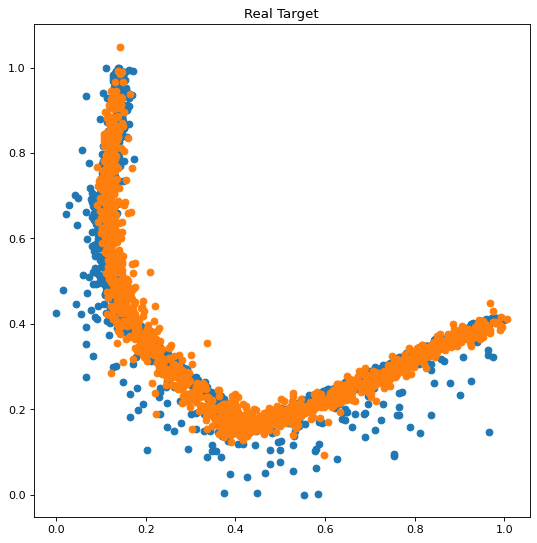

In [29]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1])
plt.scatter(rbf_krr_1.predict(x_mlcup_tr), poly_krr_2.predict(x_mlcup_tr))
plt.title("Real Target")
#plt.savefig("./plots/ml_cup/nn_RandomSearch/real_target.png")
plt.show()

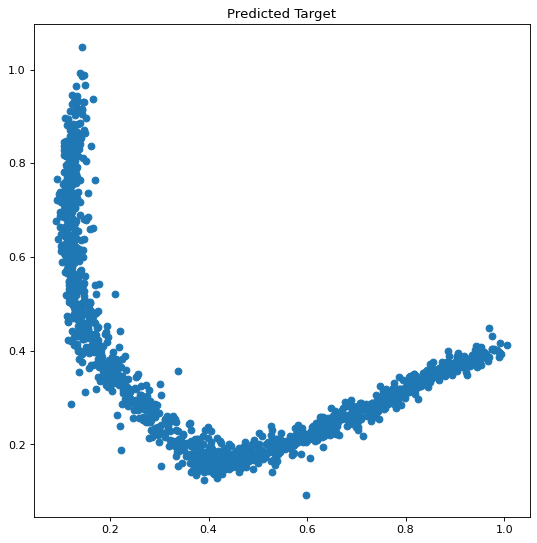

In [26]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(rbf_krr_1.predict(x_mlcup_tr), poly_krr_2.predict(x_mlcup_tr))
plt.title("Predicted Target")
#plt.savefig("./plots/ml_cup/nn_RandomSearch/real_target.png")
plt.show()